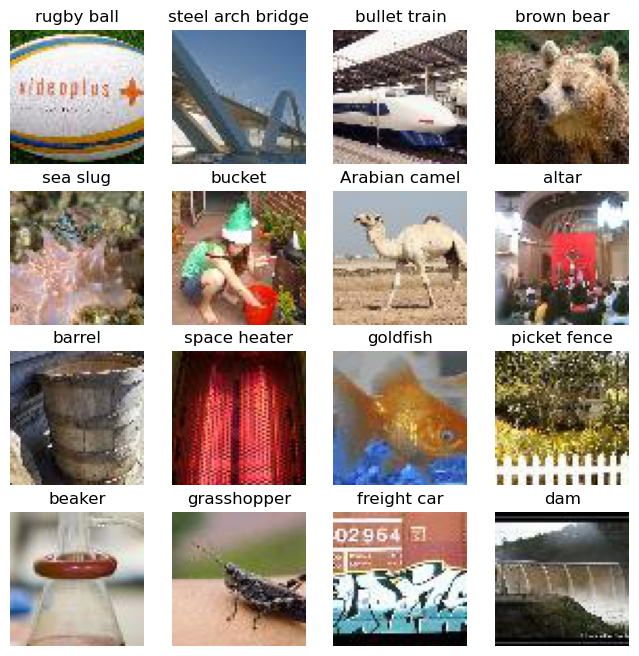

In [20]:
# 这是 Tiny Imagenet 数据集的预处理
'''
Tiny Imagenet 有 200 个类。 每个类有 500 张训练图像、50 张验证图像和 50 张测试图像。
所以一共 100000 张训练图像、10000 张验证图像和 10000 张测试图像。
train 为训练集, val 为验证集。这俩数据集有标签。
这个数据集大部分是 RGB, 但是也有少部分是灰度图。
图片大小都是 64x64。
'''
from torch.utils.data import Dataset
import os
import pandas as pd
from torchvision.io import read_image
import torch

class TinyImagenet(Dataset):
    mapping = {}    # 类的静态变量, 用来后面验证正确性用的

    def __init__(self, root, type):
        super().__init__()
        self.root = root
        self.type = type
        
        if not os.path.exists(root):
            raise ValueError("dataset path not right!")
        if type not in ['train', 'val']:
            raise ValueError("dataset type not right!")
        
        self.annotations_file = self.get_annotations_file(type)

    def get_annotations_file(self, type):
        df = pd.DataFrame(columns=['img_name', 'label'])
        rows = []
        mapping = {}
        with open(os.path.join(self.root, 'wnids.txt'), 'r') as f:
            lines = f.readlines()
            lines = [line.strip() for line in lines]
            for idx, line in enumerate(lines):
                mapping[line] = idx
                TinyImagenet.mapping[line] = idx

        if type == 'train':
            '''
            去遍历 train 下面的每个子文件夹
                对于每个子文件夹, 通过文件夹名 mapping 找到对应的 label
                对于每个子文件夹, 进入其下的 txt, 把第一列读出来, 作为 img_names, 然后把所有 pairs 存到 rows 里
            '''
            path_train = os.path.join(self.root, 'train')
            for entry in os.listdir(path_train):
                label = mapping[entry]
                with open(os.path.join(path_train, entry, entry + '_boxes.txt'), 'r') as f:
                    lines = f.readlines()
                    for line in lines:
                        img_name = line.split('\t')[0]
                        rows.append({'img_name': img_name, 'label': label})

        elif type == 'val':
            '''
            进入 val 下的 txt, 把前两列读出来, 然后用 mapping 换为 label 即可
            '''
            with open(os.path.join(self.root, 'val', 'val_annotations.txt'), 'r') as f:
                lines = f.readlines()
                for line in lines:
                    img_name, id, _, _, _, _ = line.split('\t')
                    label = mapping[id]
                    rows.append({'img_name': img_name, 'label': label})

        df = pd.concat([df, pd.DataFrame(rows)], ignore_index=True)
        return df
    
    def __len__(self):
        return len(self.annotations_file)
    
    def __getitem__(self, idx):
        label = self.annotations_file.iloc[idx, 1]
        img_name = self.annotations_file.iloc[idx, 0]

        if self.type == 'train':
            catagory = img_name.split('_')[0]
            img = read_image(os.path.join(self.root, 'train', catagory, 'images', img_name))
        elif self.type == 'val':
            img = read_image(os.path.join(self.root, 'val', 'images', img_name))

        if img.shape[0] == 1: # 有可能出现灰度图, 要转为 RGB
            img = img.repeat(3, 1, 1) # tensor.repeat(x, y, z) 表示下标为 0 的维度重复 x 次, 依次类推
        img = img.to(torch.float32) / 255.0 # read_image 读出来的是 torch.uint8, 要转为 [0, 1]

        return img, label
        
# 验证下自定义数据集声明是否正确 (检查图片与标签的对应关系)
train_TinyImagenetData = TinyImagenet(root="./data/tiny-imagenet-200", type="train")
test_TinyImagenetData = TinyImagenet(root="./data/tiny-imagenet-200", type="val")

from torch.utils.data import DataLoader
train_TinyImagenetDataloader = DataLoader(train_TinyImagenetData, batch_size=8, shuffle=True)
test_TinyImagenetDataloader = DataLoader(test_TinyImagenetData, batch_size=8, shuffle=True)

mapping = {}
with open('./data/tiny-imagenet-200/words.txt', 'r') as f:
    lines = f.readlines()
    for line in lines:
        id, desc = line.split('\t')
        mapping[TinyImagenet.mapping.get(id)] = desc.strip().split(',')[0]  # 太长了, 只取第一个

a = next(iter(train_TinyImagenetDataloader))
b = next(iter(test_TinyImagenetDataloader))
# print(a[0][x].shape, a[1][x]) # x 为 0 到 7
# print(b[0][x].shape, b[1][x]) # x 为 0 到 7

import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8, 8))
rows, cols = 4, 4
for i, j in zip(range(1, 8 + 1), range(0, 8)):
    fig.add_subplot(rows, cols, i)
    plt.title(mapping[a[1][j].item()])
    plt.axis('off')
    plt.imshow(a[0][j].permute(1, 2, 0))
for i, j in zip(range(9, 16 + 1), range(0, 8)):
    fig.add_subplot(rows, cols, i)
    plt.title(mapping[b[1][j].item()])
    plt.axis('off')
    plt.imshow(b[0][j].permute(1, 2, 0))
plt.show()

# 总结: 主要还是要把 self.annotations_file 弄出来, 这玩意弄出来后边都好写

In [21]:
# 任务:
# 1. 读入 FashionMNIST, CIFAR10, Tiny Imagenet(来自CS231n课程项目) 数据集
# 2. 构建 CNN 网络, 写 train/eval loop, 带调试信息
# 3. 训练, 保存, 加载

# 数据集导入
from torchvision import datasets, transforms

op_dataset = 2  # 0: FashionMNIST, 1: CIFAR10, 2: TinyImagenet
op_model = 0    # 0: LetNet

if op_dataset == 0:
    catagoty_num = 10
    train_data = datasets.FashionMNIST(
        root='./data',
        train=True,
        download=True,
        transform=transforms.ToTensor(),
    )
    test_data = datasets.FashionMNIST(
        root='./data',
        train=False,
        download=True,
        transform=transforms.ToTensor(),
    )
elif op_dataset == 1:
    catagoty_num = 10
    train_data = datasets.CIFAR10(
        root='./data',
        train=True,
        download=True,
        transform=transforms.ToTensor(),
    )
    test_data = datasets.CIFAR10(
        root='./data',
        train=False,
        download=True,
        transform=transforms.ToTensor(),
    )
elif op_dataset == 2:
    catagoty_num = 200
    train_data = TinyImagenet('./data/tiny-imagenet-200', 'train')
    test_data = TinyImagenet('./data/tiny-imagenet-200', 'val')

from torch.utils.data import DataLoader

batch_size = 64
train_dataloader = DataLoader(train_data, batch_size= batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=True)
print('训练集和测试集的样本数量')
print(len(train_data), len(test_data))

训练集和测试集的样本数量
100000 10000


In [22]:
# LetNet
from torch import nn

sample = train_data[0][0]

class LetNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=sample.shape[0], out_channels=6, kernel_size=5)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(self.get_flatten_dim(), 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, catagoty_num)

    def get_flatten_dim(self):
        with torch.no_grad():
            x = self.pool(self.conv1(sample.unsqueeze(0)))  # 增加 batch 维度
            x = self.pool(self.conv2(x))
            return x.numel()
        
    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.flatten(x)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        logits = self.fc3(x)
        return logits

In [23]:
# train/eval

from torch import optim

device = 'cuda' if torch.cuda.is_available() else 'cpu'
if op_model == 0:
    model = LetNet().to(device)
    model_name = 'LetNet'
    
loss_fn = nn.CrossEntropyLoss()
lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr)

def train_loop(model, dataloader, loss_fn, optimizer):
    model.train()
    samples_size = len(dataloader.dataset)
    batches_size = len(dataloader)
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        logits_pred = model(X)
        loss = loss_fn(logits_pred, y)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        if batch % 100 == 0 or batch == batches_size - 1:
            print(f'loss:{loss:>7.2f} | {batch * batch_size + len(y)}/{samples_size}')

def test_loop(model, dataloader, loss_fn):
    model.eval()
    samples_size = len(dataloader.dataset)
    batches_size = len(dataloader)
    loss_sum = 0
    acc_sum = 0
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        with torch.no_grad():
            logits_pred = model(X)
        loss_sum += loss_fn(logits_pred, y)
        acc_sum += (logits_pred.argmax(dim=1) == y).sum()
    print(f'loss:{(loss_sum/batches_size):>7.2f} | acc:{(acc_sum/samples_size*100):>7.2f}%')

epochs = 10
for t in range(1, epochs + 1):
    print(f'Epoch {t} -------------------------')
    train_loop(model, train_dataloader, loss_fn, optimizer)
    test_loop(model, test_dataloader, loss_fn)
    print()

# 保存/加载模型
import os

if not os.path.exists('./model'):
    os.makedirs('./model')
torch.save(model.state_dict(), os.path.join('./model', model_name + '.pth'))

model_new = LetNet().to(device)
model_new.load_state_dict(torch.load(os.path.join('./model', model_name + '.pth')))
model_new.eval()
with torch.no_grad():
    y_pred = model_new(sample.unsqueeze(0).to(device)).argmax()
print(y_pred, train_data[0][1])

Epoch 1 -------------------------
loss:   5.29 | 64/100000
loss:   5.25 | 6464/100000
loss:   5.10 | 12864/100000
loss:   5.21 | 19264/100000
loss:   4.98 | 25664/100000
loss:   4.79 | 32064/100000
loss:   4.87 | 38464/100000
loss:   4.92 | 44864/100000
loss:   4.84 | 51264/100000
loss:   4.61 | 57664/100000
loss:   4.77 | 64064/100000
loss:   4.72 | 70464/100000
loss:   4.61 | 76864/100000
loss:   4.74 | 83264/100000
loss:   4.66 | 89664/100000
loss:   4.45 | 96064/100000
loss:   4.18 | 100000/100000
loss:   4.56 | acc:   6.55%

Epoch 2 -------------------------
loss:   4.76 | 64/100000
loss:   4.96 | 6464/100000
loss:   4.54 | 12864/100000
loss:   4.71 | 19264/100000
loss:   4.22 | 25664/100000
loss:   4.70 | 32064/100000
loss:   4.34 | 38464/100000
loss:   4.21 | 44864/100000
loss:   4.38 | 51264/100000
loss:   4.18 | 57664/100000
loss:   4.41 | 64064/100000
loss:   4.40 | 70464/100000
loss:   4.15 | 76864/100000
loss:   4.43 | 83264/100000
loss:   4.35 | 89664/100000
loss:   4.23 |